In [3]:
import os
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import pymbar
import seaborn as sns
from matplotlib import ticker
from pymbar import timeseries

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


In [4]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)
pplt.load_cmaps()

In [6]:
color_arr = []

for r in np.arange(0, 99):
    if r >= 8 and r <= 13:
        color = "crimson"
    elif r >= 20 and r <= 34:
        color = "crimson"
    elif r >= 40 and r <= 45:
        color = "crimson"
    elif r >= 49 and r <= 55:
        color = "orchid"
    elif r >= 63 and r <= 68:
        color = "darkorange"
    elif r >= 72 and r <= 76:
        color = "forestgreen"
    elif r >= 83 and r <= 95:
        color = "mediumblue"
    else:
        color = "slategray"

    color_arr.append(color)

# Load data - For gs (all trans)

In [7]:
pdb_id = "gs_d91r"
start_frame = 2000  # skip first 2000 frames
work_dir = "/project/dinner/scguo/kaiB/remd/d91r_trans_gs/remd/"
n_rep = 48  # replica number
input_dir = f"{work_dir}/inputs"
result_dir = f"{work_dir}/outputs"

In [20]:
pot, hb, Ts, T, rgs = [], [], [], [], []
for i in range(n_rep):
    j = str(i).zfill(2)
    pot.append(np.load(f"{result_dir}/{pdb_id}.run.{j}_Energy.npy")[:, 0])
    hb.append(np.load(f"{result_dir}/{pdb_id}.run.{j}_Hbond.npy"))
    rgs.append(np.load(f"{result_dir}/{pdb_id}.run.{j}_Rg.npy"))
    t = np.load(f"{result_dir}/{pdb_id}.run.{j}_T.npy")
    nsize = pot[-1].size
    Ts.append(np.zeros(nsize) + t)
    T.append(t)

pot = np.array(pot)
hb = np.array(hb)
rgs = np.array(rgs)
Ts = np.array(Ts)
T = np.array(T)

print(pot.shape)

(48, 19999)


# weights using MBAR

In [16]:
kB = 1.0  # upside unit
beta = 1 / (kB * T)

raw_pot = pot[:, start_frame:]

nsamples_arr = np.zeros([n_rep], np.int32) + len(raw_pot[0])
reduced_pot = np.zeros([n_rep, n_rep, nsamples], np.float32)
for k in range(n_rep):
    for l in range(n_rep):
        reduced_pot[k, l] = beta[l] * raw_pot[k]

In [17]:
mbar = pymbar.MBAR(reduced_pot, nsamples_arr, verbose=True)

# Calculate melting curve using $R_g$ and hydrogen bonds

In [70]:
rg_mean = np.mean(rgs, axis=1)
hb_mean = np.mean(hb, axis=1)
rg_reweight = mbar.compute_expectations(rgs[:, start_frame:])
hb_reweight = mbar.compute_expectations(hb[:, start_frame:])

/beagle3/dinner/scguo/miniconda3/envs/py39/lib/python3.9/site-packages/pymbar/mbar.py:935: RuntimeWarning: divide by zero encountered in log
  Log_W_nk[:, sa] = np.log(A_n[i, ri]) + Log_W_nk[:, l]


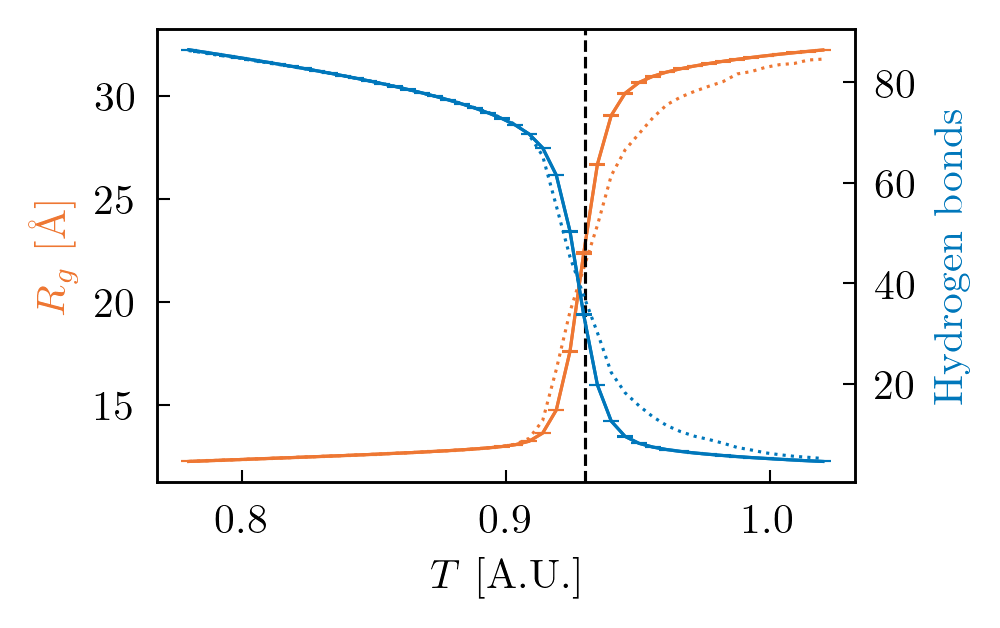

In [75]:
fig = plt.figure(figsize=(3, 2), dpi=300)
ax = plt.gca()
ax.plot(T, rg_reweight['mu'], color='C0')
ax.errorbar(T, rg_reweight['mu'], yerr=rg_reweight['sigma'], color='C0', capsize=2, capthick=0.5)
ax.plot(T, rg_mean, color="C0", ls=":")
ax.set_ylabel("$R_g$ [Å]", color='C0')
ax2 = plt.twinx()
ax2.plot(T, hb_reweight['mu'], color='C1')
ax2.errorbar(T, hb_reweight['mu'], yerr=hb_reweight['sigma'], color='C1', capsize=2, capthick=0.5)
ax2.plot(T, hb_mean, color="C1", ls=":")
ax2.set_ylabel("Hydrogen bonds", color='C1')
ax.set_xlabel("$T$ [A.U.]")
ax.axvline(0.93, zorder=5, ls='--', color='k')

# Load data - For fs (all cis)

In [76]:
pdb_id = "fs_d91r"
start_frame = 2000  # skip first 2000 frames
work_dir = "/project/dinner/scguo/kaiB/remd/d91r_cis_fs/remd/"
n_rep = 48  # replica number
input_dir = f"{work_dir}/inputs"
result_dir = f"{work_dir}/outputs"

In [77]:
pot, hb, Ts, T, rgs = [], [], [], [], []
for i in range(n_rep):
    j = str(i).zfill(2)
    pot.append(np.load(f"{result_dir}/{pdb_id}.run.{j}_Energy.npy")[:, 0])
    hb.append(np.load(f"{result_dir}/{pdb_id}.run.{j}_Hbond.npy"))
    rgs.append(np.load(f"{result_dir}/{pdb_id}.run.{j}_Rg.npy"))
    t = np.load(f"{result_dir}/{pdb_id}.run.{j}_T.npy")
    nsize = pot[-1].size
    Ts.append(np.zeros(nsize) + t)
    T.append(t)

pot = np.array(pot)
hb = np.array(hb)
rgs = np.array(rgs)
Ts = np.array(Ts)
T = np.array(T)

print(pot.shape)

(48, 19999)


# weights using MBAR

In [78]:
kB = 1.0  # upside unit
beta = 1 / (kB * T)

raw_pot = pot[:, start_frame:]

nsamples_arr = np.zeros([n_rep], np.int32) + len(raw_pot[0])
reduced_pot = np.zeros([n_rep, n_rep, nsamples], np.float32)
for k in range(n_rep):
    for l in range(n_rep):
        reduced_pot[k, l] = beta[l] * raw_pot[k]

In [79]:
mbar = pymbar.MBAR(reduced_pot, nsamples_arr, verbose=True)

# Calculate melting curve using $R_g$ and hydrogen bonds

In [80]:
rg_mean = np.mean(rgs, axis=1)
hb_mean = np.mean(hb, axis=1)
rg_reweight = mbar.compute_expectations(rgs[:, start_frame:])
hb_reweight = mbar.compute_expectations(hb[:, start_frame:])

/beagle3/dinner/scguo/miniconda3/envs/py39/lib/python3.9/site-packages/pymbar/mbar.py:935: RuntimeWarning: divide by zero encountered in log
  Log_W_nk[:, sa] = np.log(A_n[i, ri]) + Log_W_nk[:, l]


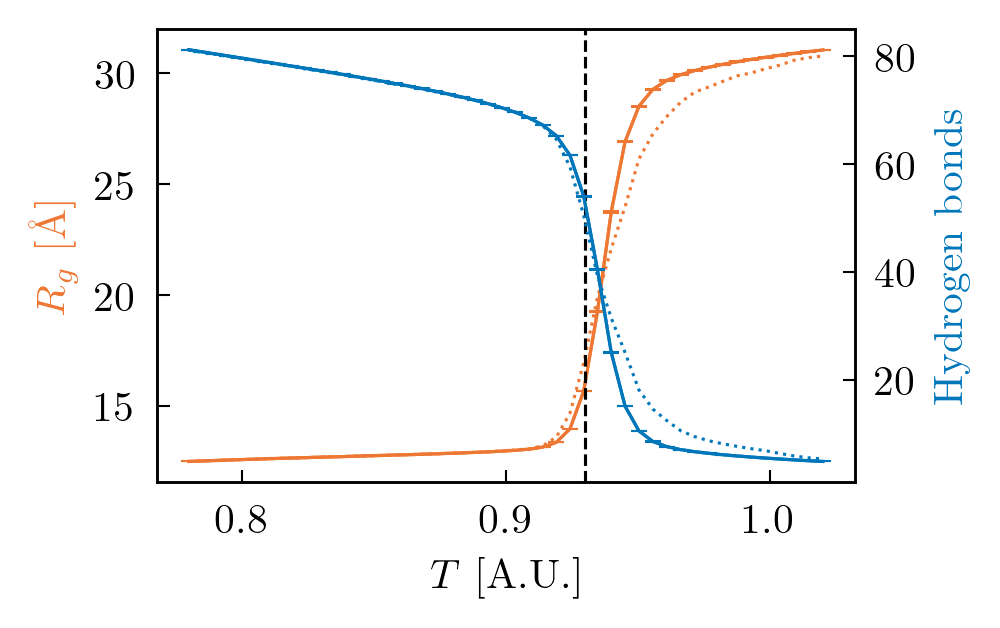

In [88]:
fig = plt.figure(figsize=(3, 2), dpi=300)
ax = plt.gca()
ax.plot(T, rg_reweight['mu'], color='C0')
ax.errorbar(T, rg_reweight['mu'], yerr=rg_reweight['sigma'], color='C0', capsize=2, capthick=0.5)
ax.plot(T, rg_mean, color="C0", ls=":")
ax.set_ylabel("$R_g$ [Å]", color='C0')
ax2 = plt.twinx()
ax2.plot(T, hb_reweight['mu'], color='C1')
ax2.errorbar(T, hb_reweight['mu'], yerr=hb_reweight['sigma'], color='C1', capsize=2, capthick=0.5)
ax2.plot(T, hb_mean, color="C1", ls=":")
ax2.set_ylabel("Hydrogen bonds", color='C1')
ax.set_xlabel("$T$ [A.U.]")
ax.axvline(0.93, zorder=5, ls='--', color='k')

In [83]:
t0, g, Neff_max = timeseries.detect_equilibration(rgs[0, :100000], nskip=10)